In [26]:
# import modules 
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt
from scipy.spatial.transform import Rotation
import time

# escolha o conjunto de imagens
path = '../../../images/virtual/'
images = glob(path + '10x7/opengl3/*.jpg')

from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# Coppelia Remote Client
client = RemoteAPIClient()
sim = client.getObject('sim')

# Get the vision sensor handle
vision_sensor_handle = sim.getObject('/Vision_sensor') 
chessboard_handle = sim.getObject('/Cuboid[3]/Dummy')
cubo = sim.getObject('/Cuboid[3]')

In [27]:
# Reconstrução do tabuleiro
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize # Square size não interfere na calibração -> somente um fator de escala
                       # o square size não é utilizado na calibração dos cara de stanford
    return X

# Detectando os corners
def detectCorners(images, boardPoints, patternSize):
    worldPoints = []
    imagePoints = [] 

    img_size = 0
    counter = 0
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]
        ret, corners = cv2.findChessboardCornersSB(gray, patternSize, None)
        if ret == True:
            #print("Corners found in image " + str(fname)) #- see if corners are found 
            #corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            worldPoints.append(boardPoints)
            imagePoints.append(corners)
            counter+=1

    print("Corners found in " + str(counter) + " images")
    #print(img_size)
    return worldPoints, imagePoints, img_size

# Calibrando a camera
def calibrate(images, useFisheye, patternSize, squareSize, details = True):

    boardPoints = construct3DPoints(patternSize, squareSize)

    worldPoints, imagePoints, imgSize = detectCorners(images, boardPoints, patternSize)

    if useFisheye:
        flagsCalib = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_CHECK_COND
        calibrateCriteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30, 1e-12)

        ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(np.expand_dims(np.asarray(worldPoints), -2), imagePoints, imgSize, None, None,
                                                                    flags=flagsCalib,criteria=calibrateCriteria)
    else:
        flagsCalib = cv2.CALIB_RATIONAL_MODEL

        ret, cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError = cv2.calibrateCameraExtended(worldPoints, imagePoints, imgSize, None, None,
                                                                flags=flagsCalib)
    if details:
        print("RMS re-projection error:", ret)
        print("The median re-projection error", np.median(perViewError))
        print("Camera Matrix:\n", cameraMatrix)
        print("Distortion Parameters:\n", k)

    return cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError, worldPoints, imagePoints

# calcular erro médio de reprojeção
def calculate_mean_error(image_set, pattern_size, square_size, camera_matrix, distortion, per_view_error = False):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []
    
    # Define the world board points
    board_points = construct3DPoints(pattern_size, square_size)
    board_points = board_points.astype('float32')
    
    # Calculate image points in each image
    for image in image_set:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect chessboard corners in the image
        ret, detected_image_points = cv2.findChessboardCornersSB(gray, pattern_size, None)
        
        # If it was detected
        if ret == True: 

            # Calculate extrinsic parameters 
            _, rvec, tvec = cv2.solvePnP(board_points, detected_image_points, camera_matrix, distortion)
            rvecs.append(rvec)
            tvecs.append(tvecs)

            # Calculate projected image points
            projected_image_points, _ = cv2.projectPoints(board_points, rvec, tvec, camera_matrix, distortion)

            # Find the Euclidean Distance between projected and detected image points
            error = cv2.norm(detected_image_points, projected_image_points, normType= cv2.NORM_L2) / len(projected_image_points)
            
            errors.append(error)
            
            if per_view_error:
                print(f"Mean Error of Image {image}:", error, "px")
    
    mean_error = np.median(errors)
    
    print("Median error: ", mean_error)
    
    return mean_error

# calcular erro rms de reprojeção
def calculate_rms_error(image_set, pattern_size, square_size, camera_matrix, distortion, per_view_error = False):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []

    # Define the world board points
    board_points = construct3DPoints(pattern_size, square_size)

    # Calculate the detected image points
    for image in image_set:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect chessboard corners in the image
        ret, corners = cv2.findChessboardCornersSB(gray, pattern_size, None)

        # If it was detected
        if ret == True:
            
            # Calculate extrinsic parameters
            _, rvec, tvec = cv2.solvePnP(board_points, corners, camera_matrix, distortion)
            rvecs.append(rvec)
            tvecs.append(tvecs)

            # Calculate projected image points
            image_points, _ = cv2.projectPoints(board_points, rvec, tvec, camera_matrix, distortion)

            # Find the Euclidean Distance between projected and detected image points
            error = cv2.norm(corners, image_points, normType= cv2.NORM_L2) / sqrt(len(image_points))
            errors.append(error)
            if per_view_error:
                print(f"RMS Error of Image {image}:", error, "px")

    rms_error = np.median(errors)

    print("Median RMS error: ", rms_error)

    return rms_error

In [28]:
# rigid transformations functions

# Random rotation matrix
def randR():
    return Rotation.from_euler('xyz', [np.random.randint(0, 360), np.random.randint(0, 360), np.random.randint(0, 360)], degrees=True).as_matrix()

# Random translation matrix
def randt(L): # Confined in a cube with an edge of length L
    return np.array([[2*L*np.random.random_sample()-L] for _ in range(3)])

# Rotate a point P in a observed frame O to be in respect to a main frame M 
def R(O, M):
    return np.array([[np.dot(O[0], M[0]), np.dot(O[1], M[0]), np.dot(O[2], M[0])],
                     [np.dot(O[0], M[1]), np.dot(O[1], M[1]), np.dot(O[2], M[1])],
                     [np.dot(O[0], M[2]), np.dot(O[1], M[2]), np.dot(O[2], M[2])]])

def RPY(R):
    return Rotation.from_rotvec(R).as_euler('xyz', degrees=True)

# Make coordinates homogeneous
def to_homo(points):
    return np.vstack((points, np.ones(points.shape[1]))) 

# Joins the rotation and translation matrices to make a homogeneous transformation
def join_homo(R, t):
    return np.vstack((np.hstack((R, t)), np.array([0, 0, 0, 1])))

# Extract the rotation and translation matrices from the homogeneous transformation
def split_homo(H):
    return H[0:3, 0:3], H[0:3 , [-1]]

# Returns the inverse of a homogeneous transformation matrix
def inverse_homo(H):
    R, t = split_homo(H)
    
    return join_homo(R.T, -R.T @ t)

# Returns the vertices of an unit cube with corner in origin
def cube(position=np.zeros(3).reshape(-1,1), size=1/2):
    vertices = np.array([[(V>>2)&1, (V>>1)&1, (V>>0)&1] for V in range(8)]).T*size+position

    return vertices

def rectangle(width = 1, height = 1):
    # Coordenadas dos vértices do retângulo
    x_coords = np.array([-width/2, width/2, width/2, -width/2])
    y_coords = np.array([height/2, height/2, -height/2, -height/2])

    # Criando um array com as coordenadas dos vértices
    rectangle_coords = np.row_stack((x_coords, y_coords,np.zeros(4)))
    
    return rectangle_coords

In [29]:
def build_intrinsic_matrix(fov_degrees, resolution):
    fov_radians = np.radians(fov_degrees)

    f_x = resolution[0]/(2*np.tan(fov_radians/2))
    f_y = resolution[1]/(2*np.tan(fov_radians/2))

    o_x = resolution[0]/2
    o_y = resolution[1]/2

    camera_matrix = np.array([[-f_x,   0, o_x, 0],
                              [  0, -f_y, o_y, 0],
                              [  0,    0,   1, 0]])

    return camera_matrix

def build_extrinsic_matrix(vision_sensor_handle, chessboard_handle = sim.handle_world):
    camera_pose = np.vstack((np.array(sim.getObjectMatrix(vision_sensor_handle, chessboard_handle)).reshape((3,4)), np.array([0, 0, 0, 1])))

    return camera_pose

def build_projection_matrix(intrinsic_matrix, extrinsic_matrix):
    projection_matrix = intrinsic_matrix @ inverse_homo(extrinsic_matrix) 

    return projection_matrix

def perspective_projection(points, projection_matrix):
    projected_point = projection_matrix @ points  # Project points to plane
    projected_point /= projected_point[-1]        # Normalize homogeneous coordinates
    projected_point = projected_point[:-1, :]     # Discard the last row
    #projected_point = projected_point.astype(int) # Cast as interger
    
    return projected_point

def sum_coord(A, B):
    for coord in range(len(A)):
        B[coord] += A[coord]
        
    return B 

In [105]:
# Dados do Coppelia
# Declare intrinsic parameters
fov_degrees = 60.0
resolution = (720,720)

# Generate intrinsic parameters matrix
intrinsic_matrix = build_intrinsic_matrix(fov_degrees, resolution) 

print(intrinsic_matrix)

[[-623.53829072    0.          360.            0.        ]
 [   0.         -623.53829072  360.            0.        ]
 [   0.            0.            1.            0.        ]]


In [104]:
intrinsic_matrix[0][0] = intrinsic_matrix[0][0] + np.random.normal(0,1)
intrinsic_matrix[1][1] = intrinsic_matrix[1][1] + np.random.normal(0,1)

new_matrix = intrinsic_matrix

print(intrinsic_matrix)

[[-624.40024382    0.          360.            0.        ]
 [   0.         -624.84651782  360.            0.        ]
 [   0.            0.            1.            0.        ]]


RMS re-projection error: 1.5878163616953664e-05
Camera Matrix:
 [[590.75970914   0.         359.49999572]
 [  0.         656.34212136 359.50000312]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-4.19525638e-05 -1.10521432e-04  1.91102467e-08 -1.84615234e-08
  -1.22464823e-04 -4.18076838e-05 -1.10947379e-04 -1.22259448e-04
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Per View Standart Deviation: 3.620142734810804e-06


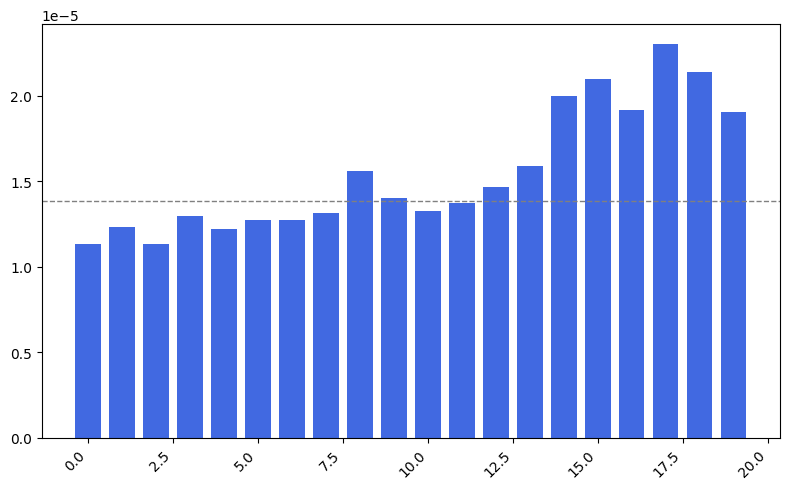

In [74]:
images_points = []
world_points = []

patternSize = (7,7)

# Start simulation in CoppeliaSim

sim.startSimulation()

# Number of calibration images
number_of_images = 20

# See the Vision sensor image

for i in range(number_of_images):
    
    p=sim.getObjectPosition(cubo,-1)

    ds = randt(0.2)
    coord = sum_coord(p, ds).tolist()
    coord = [coord[0][0], coord[1][0], coord[2][0]]
    
    sim.setObjectPosition(cubo,-1, coord)
    
    extrinsic_matrix = build_extrinsic_matrix(vision_sensor_handle, chessboard_handle)
    
    projection_matrix = build_projection_matrix(intrinsic_matrix, extrinsic_matrix)

    board_points = construct3DPoints(patternSize = (7,7), squareSize = 0.1)

    world_points.append(board_points)
    
    points_to_project = to_homo(board_points.T) 

    projected_points = perspective_projection(points_to_project, projection_matrix)
    
    projected_points = projected_points.T

    images_points.append(projected_points)
    
    time.sleep(0.5)

sim.stopSimulation()

corrected_image_points_vector = []
corrected_world_points_vector = []
for image in images_points:
    image = image.astype(np.float32)
    corrected_image_points_vector.append(image.reshape(49,1,2))

for world in world_points:
    world = world.astype(np.float32)
    corrected_world_points_vector.append(world.reshape(49,1,3))

imgSize = (720,720)
flagsCalib = cv2.CALIB_RATIONAL_MODEL

ret, cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError = cv2.calibrateCameraExtended(corrected_world_points_vector, corrected_image_points_vector, imgSize, None, None,
                                                                flags=flagsCalib)
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", k)
print("Per View Standart Deviation:", perViewError.std())

perViewError = perViewError.flatten()
rms_error = np.median(perViewError)
idxs = []
for i, idx in enumerate(images_points):
    idxs.append(i)

plt.figure(figsize=(8,5))
plt.bar(idxs, perViewError, color = 'royalblue', width=.75)

plt.axhline(y=rms_error, color='gray', linestyle='--', linewidth=1, label=f'Média: {rms_error:.2f}')

plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos das imagens para melhor visualização
plt.tight_layout()  # Ajusta o layout para se encaixar bem na figura
plt.show()

In [106]:
extrinsic_matrix = build_extrinsic_matrix(vision_sensor_handle, chessboard_handle)
    
projection_matrix = build_projection_matrix(intrinsic_matrix, extrinsic_matrix)

board_points = construct3DPoints(patternSize = (7,7), squareSize = 0.1)

world_points.append(board_points)
    
points_to_project = to_homo(board_points.T) 

projected_points = perspective_projection(points_to_project, projection_matrix)

In [107]:
extrinsic_matrix = build_extrinsic_matrix(vision_sensor_handle, chessboard_handle)
    
projection_matrix = build_projection_matrix(new_matrix, extrinsic_matrix)

board_points = construct3DPoints(patternSize = (7,7), squareSize = 0.1)

world_points.append(board_points)
    
points_to_project = to_homo(board_points.T) 

new_projected_points = perspective_projection(points_to_project, projection_matrix)

In [110]:
projected_points.T

array([[247.2431631 , 272.59689869],
       [280.06806257, 273.36595857],
       [312.30767411, 274.12130564],
       [343.97751578, 274.86330348],
       [375.09255268, 275.59230271],
       [405.66724168, 276.30864204],
       [435.71554612, 277.01264862],
       [247.23575522, 304.22335099],
       [280.34889267, 304.71216906],
       [312.86646596, 305.19219537],
       [344.80440174, 305.66366504],
       [376.17805451, 306.12680473],
       [407.0022526 , 306.58183334],
       [437.29131376, 307.02896223],
       [247.2282149 , 336.41519666],
       [280.63469727, 336.61363274],
       [313.43506622, 336.80846849],
       [345.64567144, 336.999801  ],
       [377.28227047, 337.1877239 ],
       [408.36007594, 337.37232753],
       [438.89377211, 337.55369913],
       [247.22053856, 369.18773641],
       [280.92560974, 369.08523718],
       [314.01373546, 368.98461412],
       [346.50170354, 368.88581618],
       [378.40568881, 368.78879416],
       [409.74130157, 368.6935006 ],
 

In [109]:
new_projected_points.T

array([[247.0872928 , 272.41352085],
       [279.95756803, 273.18419427],
       [312.24174624, 273.94112611],
       [343.95536697, 274.68468071],
       [375.11341599, 275.41520944],
       [405.73037016, 276.1330517 ],
       [435.82021211, 276.83853534],
       [247.07987467, 304.10632766],
       [280.23878633, 304.59617131],
       [312.80131055, 305.07720475],
       [344.78339598, 305.5496636 ],
       [376.20041837, 306.01377499],
       [407.06722653, 306.46975828],
       [437.39815802, 306.91782527],
       [247.07232393, 336.36571409],
       [280.52498601, 336.5645665 ],
       [313.37069681, 336.75981103],
       [345.62582862, 336.95154497],
       [377.30616075, 337.13986214],
       [408.42692687, 337.32485309],
       [439.00283154, 337.50660522],
       [247.06463698, 369.20701292],
       [280.81630064, 369.10429864],
       [313.95016598, 369.00346447],
       [346.48304406, 368.90445924],
       [378.43113205, 368.80723367],
       [409.81006185, 368.71174018],
 

In [108]:
error = cv2.norm(new_projected_points, projected_points, normType= cv2.NORM_L2) / sqrt(len(projected_points))
error

0.814178423952103